In [1]:
import numpy as np
import scipy
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# part a)
Id = sparse.csr_matrix(np.eye(2))
Sx = sparse.csr_matrix([[0., 1.], [1., 0.]])
Sz = sparse.csr_matrix([[1., 0.], [0., -1.]])
print(Sz.shape)
print(Id)
print(Id.toarray())

(2, 2)
  (0, 0)	1.0
  (1, 1)	1.0
[[1. 0.]
 [0. 1.]]


In [3]:
# part b)
def singlesite_to_full(op, i, L):
    op_list = [Id]*L  # = [Id, Id, Id ...] with L entries
    op_list[i] = op
    full = op_list[0]
    for op_i in op_list[1:]:
        full = sparse.kron(full, op_i, format="csr")
    return full

def gen_sx_list(L):
    return [singlesite_to_full(Sx, i, L) for i in range(L)]

# part c)

def gen_sz_list(L):
    return [singlesite_to_full(Sz, i, L) for i in range(L)]

In [8]:
# part d)

def gen_hamiltonian(sx_list, sz_list, g, J=1.):
    L = len(sx_list)
    H = sparse.csr_matrix((2**L, 2**L))
    for j in range(L):
        H = H - J *( sx_list[j] * sx_list[(j+1)%L])
        H = H - g * sz_list[j]
    return H

In [14]:
# check in part d)
L = 2
sx_list = gen_sx_list(L)
sz_list = gen_sz_list(L)
H = gen_hamiltonian(sx_list, sz_list, 0.1)
print("H for L=2, g=0.1")
print(H.toarray())

H for L=2, g=0.1
[[-0.2  0.   0.  -2. ]
 [ 0.   0.  -2.   0. ]
 [ 0.  -2.   0.   0. ]
 [-2.   0.   0.   0.2]]


In [15]:
sx_list

[<4x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 4 stored elements in Compressed Sparse Row format>,
 <4x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 4 stored elements in Compressed Sparse Row format>]

In [10]:
# part e)
L = 12
sx_list = gen_sx_list(L)
sz_list = gen_sz_list(L)
H = gen_hamiltonian(sx_list, sz_list, 0.1)
Hdense = H.toarray()
print("L =12: H =", repr(H))
E1, v1 = sparse.linalg.eigsh(H, k=3, which='SA')
E2, v2 = np.linalg.eigh(Hdense)
print(E1)
print(E2[:3])

L =12: H = <4096x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 52762 stored elements in Compressed Sparse Row format>
[-12.0300188  -12.0300188   -8.41490644]
[-12.0300188  -12.0300188   -8.41490644]


In [ ]:
%%timeit
sparse.linalg.eigsh(H, k=3, which='SA')

76.7 ms ± 3.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
np.linalg.eigh(Hdense)

8.31 s ± 212 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


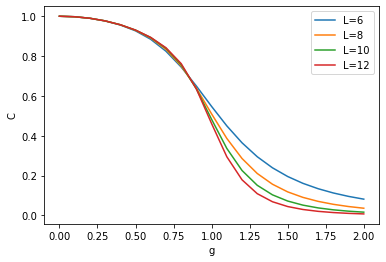

In [ ]:
# part f)

Ls = [6, 8, 10, 12]
gs = np.linspace(0., 2., 21)

plt.figure()
for L in Ls:
    sx_list = gen_sx_list(L)
    sz_list = gen_sz_list(L)
    sxsx = sx_list[0]*sx_list[L//2]
    corrs = []
    for g in gs:
        H = gen_hamiltonian(sx_list, sz_list, g, J=1.)
        E, v = sparse.linalg.eigsh(H, k=3, which='SA')
        v0 = v[:, 0]  # first column of v is the ground state
        corr = np.inner(v0.conj(), sxsx*v0)
        corrs.append(corr)
    corrs = np.array(corrs)
    plt.plot(gs, corrs, label="L={L:d}".format(L=L))
plt.xlabel("g")
plt.ylabel("C")
plt.legend()
plt.show()

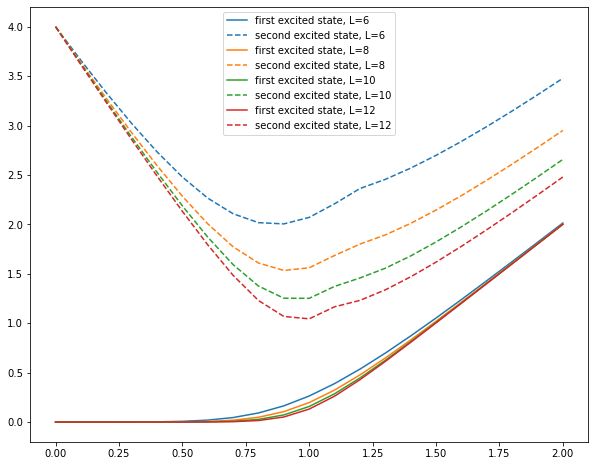

In [ ]:
# part g)
plt.figure(figsize=(10, 8))
for L in [6, 8, 10, 12]:
    sx_list = gen_sx_list(L)
    sz_list = gen_sz_list(L)
    gaps = []
    for g in gs:
        H = gen_hamiltonian(sx_list, sz_list, g, J=1.)
        E, v = sparse.linalg.eigsh(H, k=3, which='SA')
        gaps.append((E[1] - E[0], E[2] - E[0]))
    
    gaps = np.array(gaps)
    
    lines = plt.plot(gs, gaps[:, 0], linestyle='-', label="first excited state, L={L:d}".format(L=L))
    plt.plot(gs, gaps[:, 1], color = lines[0].get_color(), linestyle='--', label="second excited state, L={L:d}".format(L=L))
plt.legend()
plt.show()

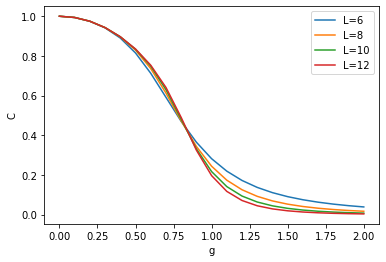

In [ ]:
# just for fun: regenerate the correlation plot  with open boundary conditions

def gen_hamiltonian_open_bc(sx_list, sz_list, g, J=1.):
    L = len(sx_list)
    H = sparse.csr_matrix((2**L, 2**L))
    for j in range(L):
        if j < L-1:
            H = H - J *( sx_list[j] * sx_list[j+1])
        H = H - g * sz_list[j]
    return H

plt.figure()
for L in Ls:
    sx_list = gen_sx_list(L)
    sz_list = gen_sz_list(L)
    sxsx = sx_list[0]*sx_list[L//2]
    corrs = []
    for g in gs:
        H = gen_hamiltonian_open_bc(sx_list, sz_list, g, J=1.)
        E, v = sparse.linalg.eigsh(H, k=3, which='SA')
        v0 = v[:, 0]  # first column of v is the ground state
        corr = np.inner(v0, sxsx*v0)
        corrs.append(corr)
    corrs = np.array(corrs)
    plt.plot(gs, corrs, label="L={L:d}".format(L=L))
plt.xlabel("g")
plt.ylabel("C")
plt.legend()
plt.show()

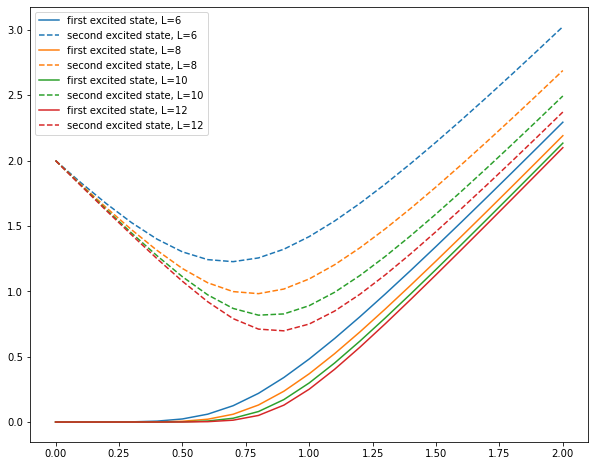

In [ ]:
# and the plot for the excitation energies for open b.c.

plt.figure(figsize=(10, 8))
for L in [6, 8, 10, 12]:
    sx_list = gen_sx_list(L)
    sz_list = gen_sz_list(L)
    gaps = []
    for g in gs:
        H = gen_hamiltonian_open_bc(sx_list, sz_list, g, J=1.)
        E, v = sparse.linalg.eigsh(H, k=3, which='SA')
        gaps.append((E[1] - E[0], E[2] - E[0]))

    gaps = np.array(gaps)
    lines = plt.plot(gs, gaps[:, 0], linestyle='-', label="first excited state, L={L:d}".format(L=L))
    plt.plot(gs, gaps[:, 1], color = lines[0].get_color(), linestyle='--', label="second excited state, L={L:d}".format(L=L))
plt.legend()
plt.show()

In [ ]:
# For comparison on the next sheet:
L = 10
sx_list = gen_sx_list(L)
sz_list = gen_sz_list(L)
H = gen_hamiltonian(sx_list, sz_list, g=0.1, J=1.)
E, v = sparse.linalg.eigsh(H, k=3, which='SA')
print(E[0])

-10.025015664234312
